# PlotResults.ipynb
### example notebook demonstrating how to plot and inspect simulation outputs

In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

In [2]:
from MADLens.util import *

### list all possible run files

In [3]:
run_dir   = '../runs'

githashes = os.listdir(run_dir)
for githash in githashes:
    print(githash)
    path = os.path.join(run_dir,githash)
    print(os.listdir(path))

2120673
['small_run.json', 'test_run_20.json', 'small_run_0.json', 'test_run_40.json', 'test_run_00.json', 'small_run_10.json', 'small_run_00.json', 'test_run_30.json', 'test_run_10.json']
c0f314b
['deriv_run0.json']
b2f7b0b
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
cd8f0a9
['med_res0.json', 'small_res0.json']
37951ca
['transfer_test0.json']
eba3a69
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
9481ab1
['small_run.json']
e6fc19b
['transfer_test0.json']
6a89a8b
['deriv_run0.json']
e94b9ae
['transfer_test0.json']
912403a
['deriv_run0.json']
d1a9163
['transfer_test0.json']
de321bb
['small_run.json']
53bbbde
['deriv_run0.json']
58fb8b3
['small_run.json']
5d6669a
['transfer_test0.json']
eb13929
['transfer_test0.json']
43458b5
['small_run.json']
106b3db
['small_run.json']
f05cdbe
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']


In [4]:
z1_runs={}

In [5]:
z1_runs['512']={}
z1_runs['256']={}
z1_runs['128']={}
z1_runs['128']['interp']={}
z1_runs['256']['interp']={}
z1_runs['512']['interp']={}
z1_runs['256']['no_interp']={}

### choose a run and load results into memory

In [6]:
run = Run(githash='7c021ff', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts()
z1_runs['256']['no_interp']['1.2']=run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 1.20, PGD True and interpolation False.


In [7]:
run.get_Pks()

True

In [8]:
run.pks

{'0.3402061855670102': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec11de50>,
 '0.5853658536585367': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec10fbd0>,
 '0.023622047244094446': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec4f3550>,
 '0.2999999999999998': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec50a750>,
 '0.0': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaaf417190>,
 '0.2264150943396226': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec506950>,
 '0.5294117647058822': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec506f90>,
 '0.07438016528925617': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec50d510>,
 '1.03125': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec116ed0>,
 '0.2621359223300972': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec116fd0>,
 '0.1607142857142856': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec511fd0>,
 '0.7105263157894737': <nbodykit.algorithms.fftpower.FFTPower at 0x2aaaec1166d0>,
 '0.13043478260869557': <nbodykit.algor

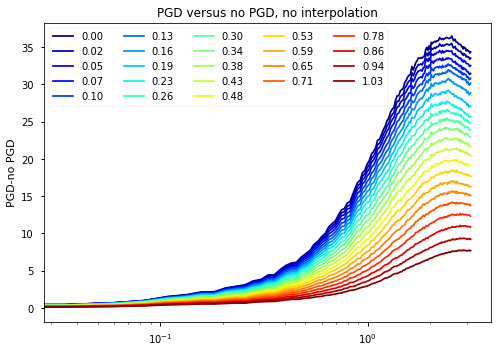

In [24]:
# PGD is continuous
plt.title('PGD versus no PGD, no interpolation')
colors = plt.cm.jet(np.linspace(0,1,len(run.pks.keys())))
for ii, zf in enumerate(sorted(run.pks.keys())):
    plt.semilogx(run.pks_PGD[zf].power['k'],(abs(run.pks_PGD[zf].power['power'])-abs(run.pks[zf].power['power'])), label='%.2f'%float(zf),c=colors[ii])
plt.legend(ncol=5)
plt.ylabel('PGD-no PGD')
plt.show()

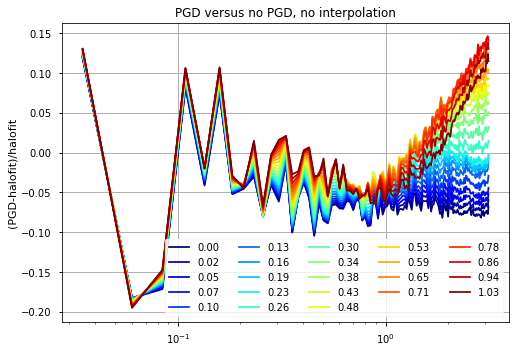

In [30]:
# PGD is continuous
plt.title('PGD versus no PGD, no interpolation')
colors = plt.cm.jet(np.linspace(0,1,len(run.pks.keys())))
for ii, zf in enumerate(sorted(run.pks.keys())):
    plt.semilogx(run.pks_PGD[zf].power['k'],(abs(run.pks_PGD[zf].power['power'])-abs(run.halofit[zf]))/abs(run.halofit[zf]), label='%.2f'%float(zf),c=colors[ii])
plt.legend(ncol=5)
plt.grid()
plt.ylabel('(PGD-halofit)/halofit')
plt.show()

In [7]:
run = Run(githash='cc1039f', label='transfer_test', rnum=0, local_path='../', alter_path='/global/cscratch1/sd/vboehm/MADLensOutputs/')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts()
z1_runs['512']['interp']['1.5']=run


Loading run with BoxSize 512, Resolution 512, SourceRedshift 1.50, PGD True and interpolation True.


FileNotFoundError: [Errno 2] No such file or directory: '/global/u2/v/vboehm/codes/MADLens/results/cc1039f/transfer_test0/maps'

In [ ]:
run = Run(githash='d1a9163', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts()
z1_runs['128']['interp']['0.5']=run

In [32]:
run = Run(githash='c21727b', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts()
z1_runs['256']['interp']['0.5']=run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 0.50, PGD True and interpolation True.


In [33]:
run = Run(githash='56bbd9b', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts()
z1_runs['256']['interp']['0.8']=run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 0.80, PGD True and interpolation True.


In [36]:
run = Run(githash='e94b9ae', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts()
z1_runs['256']['interp']['1.2'] = run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 1.20, PGD True and interpolation True.


In [ ]:
# load a single map kappa map at a specific source redhsift into memory
mymap = z1_runs['256']['interp']['1.0'].get_map(z_source=z1_runs['256']['interp']['1.0'].params['zs_source'][0],num=0)
down_sampled_map = downsample_map(mymap,512,z1_runs['256']['interp']['1.0'].params)

### plot results

In [ ]:
plt.figure()
plt.title('convergence histogram')
#_ = plt.hist(mymap.value.flatten(),bins=100,density=True, log=True)
_ = plt.hist(down_sampled_map.value.flatten(),bins=100,density=True, log=True)
mean = np.mean(mymap)
plt.axvline(x=mean,color='crimson', label='mean=%.1f'%mean)
plt.legend(fontsize=14)
plt.show()

In [ ]:
down_sampled_map = downsample_map(mymap,512,z1_runs['256']['interp']['1.0'].params)
plt.figure(figsize=(8,8))
plt.title('convergence map')
plt.imshow(np.log(down_sampled_map+1),cmap='viridis')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.colorbar()
plt.show()

<Figure size 360x288 with 0 Axes>

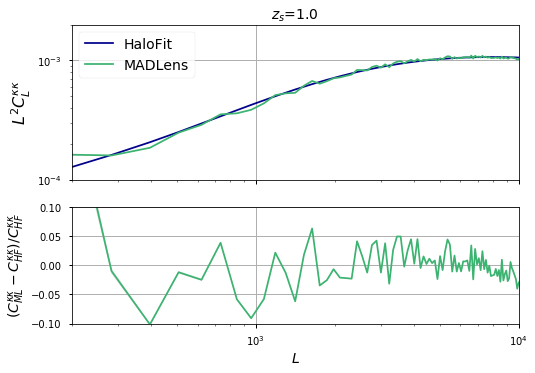

In [19]:

ll   = len(z1_runs['256']['interp']['1.0'].params['zs_source'])

plt.figure(figsize=(ll*5,4))
for ii, zs in enumerate(z1_runs['256']['interp']['1.0'].params['zs_source']):
    
    x    = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['L']
    y    = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['clkk']
    yerr = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['N']
    yt   = z1_runs['256']['interp']['1.0'].theory_cls[str(zs)]['clkk']
    
    ratio = (y-yt)/yt
    ratio_error = (yerr)/yt 
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
    ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
    ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
    ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
    ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
    ax[0].grid()
    
    ax[1].semilogx(x,ratio, color='mediumseagreen')
    ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
    ax[1].grid()
    ax[1].set_ylim(-0.1,0.1)
    ax[1].set_ylabel('relative difference')
    ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
    ax[1].set_xlabel('$L$',fontsize=14)
    ax[0].set_xlim(200,10000)
    ax[0].set_ylim(1e-4,2e-3)

In [20]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['no_interp'][1.0].params['zs_source'])

plt.figure(figsize=(ll*5,4))

    
x    = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['L']
y    = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['no_interp'][1.0].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(1e-4,2e-3)

KeyError: 1.0

(0.0001, 0.003)

<Figure size 360x288 with 0 Axes>

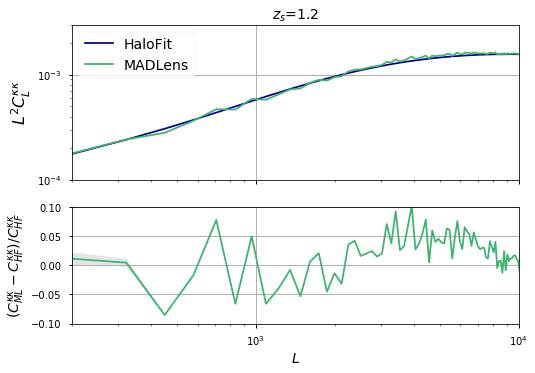

In [40]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['1.2'].params['zs_source'])
zs   = 1.2
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['1.2'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(1e-4,3e-3)

(8e-05, 0.001)

<Figure size 360x288 with 0 Axes>

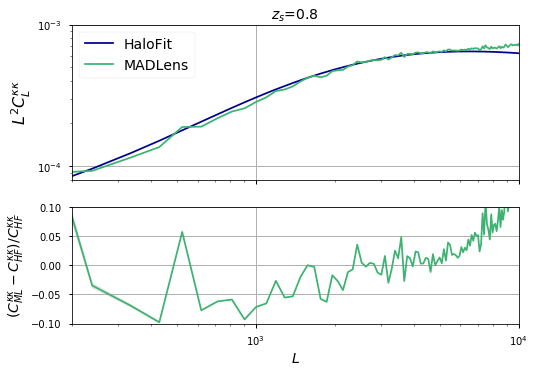

In [22]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['0.8'].params['zs_source'])
zs   = 0.8
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['0.8'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(8e-5,1e-3)

In [2]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['0.5'].params['zs_source'])
zs   = 0.5
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['0.5'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(8e-5,1e-3)

NameError: name 'z1_runs' is not defined

In [127]:
z1_runs['256']['interp'].keys()

dict_keys(['1.0', '0.5'])

In [128]:
z1_runs['256']['interp']['0.5']